In [1]:
import vectorbt as vbt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.graph_objs as go

import datetime

from plotly.subplots import make_subplots

plt.style.use('ggplot')

In [2]:
def process_signals(df, signals):
    df_signal = pd.DataFrame(signals)
    df_result = {}
    for day, df_day in df_signal.groupby(pd.Grouper(level='datetime', freq='D')):
        if df_day.shape[0] == 0:
            continue

        entry_long = df_day[df_day.entries == True]
        entry_short = df_day[df_day.short_entries == True]

        if entry_long.shape[0] != 0:
            trade_exit = df_day[df_day.exits == True].index
            trade_entry = entry_long.index
            position = 'long'
        elif entry_short.shape[0] != 0:
            trade_exit = df_day[df_day.short_exits == True].index
            trade_entry = entry_short.index
            position = 'short'
        else:
            continue

        entry_price = df.loc[trade_entry].close.values[0]
        exit_price = df.loc[trade_exit].close.values[0]

        returns = (exit_price - entry_price) / entry_price
        returns = returns * (1 if position == 'long' else -1)

        df_result[trade_exit.date[0]] = {
            'position': position,
            'entry_time': trade_entry.time[0],
            'exit_time': trade_exit.time[0],
            'entry_price': entry_price,
            'exit_price': exit_price,
            'return': returns
        }

    df_result = pd.DataFrame(df_result).T

    return df_result

In [3]:
with pd.HDFStore('./large_files/data_20240312.h5', mode='r') as store:
    df_ = store.get('data/cl')
df_.info(verbose=3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2529084 entries, 525 to 5683617
Data columns (total 10 columns):
 #   Column    Dtype                           
---  ------    -----                           
 0   date      object                          
 1   time      object                          
 2   open      float64                         
 3   high      float64                         
 4   low       float64                         
 5   close     float64                         
 6   volume    int64                           
 7   datetime  datetime64[ns, America/New_York]
 8   day       object                          
 9   month     int64                           
dtypes: datetime64[ns, America/New_York](1), float64(4), int64(2), object(3)
memory usage: 212.2+ MB


In [4]:
df = df_.set_index('datetime', drop=False)
df = df.loc[df.index.year.isin([2021, 2022, 2023])]
df = df.loc[df.index.day_of_week == 2]
df = df[(df.index.hour >= 9) & (df.index.hour < 12)]

In [5]:
df_year = df_.set_index('datetime', drop=False)
df_year = df_year.loc[df_year.index.year.isin([2024])]
df_year = df_year.loc[df_year.index.day_of_week == 2]
df_year = df_year[(df_year.index.hour >= 9) & (df_year.index.hour < 12)]

In [6]:
df_final = {}

# Hold

In [7]:
def hold_strategy(df):
    long_entry_signals = []
    long_exit_signals = []
    for day, df_day in df.groupby(pd.Grouper(key='datetime', freq='D')):
        if df_day.shape[0] == 0:
            continue
        
        df_day = df_day.copy()

        long_entry = pd.Series(False, index=df_day.index)
        long_exit = pd.Series(False, index=df_day.index)

        for time, row in df_day.iterrows():
            time = time.time()

            if (time == pd.Timestamp('11:59').time()):
                long_exit[time] = True
            elif (time == pd.Timestamp('10:30').time()):
                long_entry[time] = True

        long_entry_signals.append(long_entry)
        long_exit_signals.append(long_exit)

    long_entry_signals = pd.concat(long_entry_signals)
    long_exit_signals = pd.concat(long_exit_signals)

    return {
        'entries': long_entry_signals,
        'exits': long_exit_signals
    }

In [8]:
signals = hold_strategy(df)
portfolio = vbt.Portfolio.from_signals(
    close=df['close'],
    freq='1m',
    allow_partial=True,
    **signals
)
# portfolio = vbt.Portfolio.from_holding(
#     close=df['close'],
#     freq='1m'
# )
df_final['hold'] = portfolio.stats()
portfolio.stats()

Start                         2021-01-06 09:00:00-05:00
End                           2023-12-27 11:59:00-05:00
Period                                 19 days 12:00:00
Start Value                                       100.0
End Value                                     97.249996
Total Return [%]                              -2.750004
Benchmark Return [%]                          48.829766
Max Gross Exposure [%]                            100.0
Total Fees Paid                                     0.0
Max Drawdown [%]                              13.100505
Max Drawdown Duration                  17 days 03:21:00
Total Trades                                        156
Total Closed Trades                                 156
Total Open Trades                                     0
Open Trade PnL                                      0.0
Win Rate [%]                                       50.0
Best Trade [%]                                 2.675946
Worst Trade [%]                               -2

In [9]:
portfolio.plot()

FigureWidget({
    'data': [{'legendgroup': '0',
              'line': {'color': '#1f77b4'},
              'name': 'Close',
              'showlegend': True,
              'type': 'scatter',
              'uid': '1ce4a6bb-35a3-49ca-b336-a9dcab7848d0',
              'x': array([datetime.datetime(2021, 1, 6, 9, 0, tzinfo=<DstTzInfo 'America/New_York' EST-1 day, 19:00:00 STD>),
                          datetime.datetime(2021, 1, 6, 9, 1, tzinfo=<DstTzInfo 'America/New_York' EST-1 day, 19:00:00 STD>),
                          datetime.datetime(2021, 1, 6, 9, 2, tzinfo=<DstTzInfo 'America/New_York' EST-1 day, 19:00:00 STD>),
                          ...,
                          datetime.datetime(2023, 12, 27, 11, 57, tzinfo=<DstTzInfo 'America/New_York' EST-1 day, 19:00:00 STD>),
                          datetime.datetime(2023, 12, 27, 11, 58, tzinfo=<DstTzInfo 'America/New_York' EST-1 day, 19:00:00 STD>),
                          datetime.datetime(2023, 12, 27, 11, 59, tzinfo=<DstTz

# Simple SMA

In [10]:
def simple_sma(df, window=30, long_entry_threshold=-3.0, long_exit_threshold=0):
    long_entry_signals = []
    long_exit_signals = []
    
    for day, df_day in df.groupby(pd.Grouper(key='datetime', freq='D')):
        if df_day.shape[0] == 0:
            continue
        
        df_day = df_day.copy()
        fast_sma = vbt.MA.run(df_day.close, window=5)
        slow_sma = vbt.MA.run(df_day.close, window=15)

        long_entry = fast_sma.ma_crossed_above(slow_sma)
        long_exit = fast_sma.ma_crossed_below(slow_sma)

        long_entry_signals.append(long_entry)
        long_exit_signals.append(long_exit)
    long_entry_signals = pd.concat(long_entry_signals)
    long_exit_signals = pd.concat(long_exit_signals)

    return {
        'entries': long_entry_signals,
        'exits': long_exit_signals
    }

In [11]:
signals = simple_sma(df)
portfolio = vbt.Portfolio.from_signals(
    close=df['close'],
    freq='1m',
    allow_partial=True,
    **signals
)
df_final['sma'] = portfolio.stats()
portfolio.stats()

Start                         2021-01-06 09:00:00-05:00
End                           2023-12-27 11:59:00-05:00
Period                                 19 days 12:00:00
Start Value                                       100.0
End Value                                     69.120975
Total Return [%]                             -30.879025
Benchmark Return [%]                          48.829766
Max Gross Exposure [%]                            100.0
Total Fees Paid                                     0.0
Max Drawdown [%]                               57.27676
Max Drawdown Duration                  11 days 20:17:00
Total Trades                                        977
Total Closed Trades                                 977
Total Open Trades                                     0
Open Trade PnL                                      0.0
Win Rate [%]                                  32.753327
Best Trade [%]                                 9.261332
Worst Trade [%]                              -17

In [12]:
portfolio.plot()

FigureWidget({
    'data': [{'legendgroup': '0',
              'line': {'color': '#1f77b4'},
              'name': 'Close',
              'showlegend': True,
              'type': 'scatter',
              'uid': '015c7aa8-4c54-4a90-95a8-f297d28a2b9e',
              'x': array([datetime.datetime(2021, 1, 6, 9, 0, tzinfo=<DstTzInfo 'America/New_York' EST-1 day, 19:00:00 STD>),
                          datetime.datetime(2021, 1, 6, 9, 1, tzinfo=<DstTzInfo 'America/New_York' EST-1 day, 19:00:00 STD>),
                          datetime.datetime(2021, 1, 6, 9, 2, tzinfo=<DstTzInfo 'America/New_York' EST-1 day, 19:00:00 STD>),
                          ...,
                          datetime.datetime(2023, 12, 27, 11, 57, tzinfo=<DstTzInfo 'America/New_York' EST-1 day, 19:00:00 STD>),
                          datetime.datetime(2023, 12, 27, 11, 58, tzinfo=<DstTzInfo 'America/New_York' EST-1 day, 19:00:00 STD>),
                          datetime.datetime(2023, 12, 27, 11, 59, tzinfo=<DstTz

# Mean Reversion 1
1. Open position between 1025 and 1035
1. Go long if z-score less than threshold
1. Close before 1200 or if z-score reverts

In [13]:
def mean_reversion1(df, window=30, long_entry_threshold=-3.0, long_exit_threshold=0):
    long_entry_signals = []
    long_exit_signals = []
    
    for day, df_day in df.groupby(pd.Grouper(key='datetime', freq='D')):
        if df_day.shape[0] == 0:
            continue
        
        df_day = df_day.copy()
        df_day['z_score'] = (df_day.close - df_day.close.rolling(window).mean()) / df_day.close.rolling(window).std()

        long_entry = pd.Series(False, index=df_day.index)
        long_exit = pd.Series(False, index=df_day.index)

        for time, row in df_day.iterrows():
            time = time.time()

            if long_entry.any():
                if (row.z_score >= long_exit_threshold) or (time == pd.Timestamp('11:59').time()):
                    long_exit[time] = True
                    break
            elif (time >= pd.Timestamp('10:25').time()) & (time <= pd.Timestamp('10:35').time()) & (row.z_score < long_entry_threshold):
                long_entry[time] = True
        
        if long_entry.any():
            assert long_exit.any(), f'{day} has no exit signal'

        long_entry_signals.append(long_entry)
        long_exit_signals.append(long_exit)

    long_entry_signals = pd.concat(long_entry_signals)
    long_exit_signals = pd.concat(long_exit_signals)

    return {
        'entries': long_entry_signals,
        'exits': long_exit_signals
    }

In [14]:
signals = mean_reversion1(df)
portfolio = vbt.Portfolio.from_signals(
    close=df['close'],
    freq='1m',
    allow_partial=True,
    **signals
)
df_final['mr1'] = portfolio.stats()
portfolio.stats()

Start                         2021-01-06 09:00:00-05:00
End                           2023-12-27 11:59:00-05:00
Period                                 19 days 12:00:00
Start Value                                       100.0
End Value                                    104.306599
Total Return [%]                               4.306599
Benchmark Return [%]                          48.829766
Max Gross Exposure [%]                            100.0
Total Fees Paid                                     0.0
Max Drawdown [%]                               2.212927
Max Drawdown Duration                   1 days 02:53:00
Total Trades                                         13
Total Closed Trades                                  13
Total Open Trades                                     0
Open Trade PnL                                      0.0
Win Rate [%]                                  92.307692
Best Trade [%]                                 0.672704
Worst Trade [%]                               -1

In [15]:
portfolio.plot()

FigureWidget({
    'data': [{'legendgroup': '0',
              'line': {'color': '#1f77b4'},
              'name': 'Close',
              'showlegend': True,
              'type': 'scatter',
              'uid': '4b73850f-5b81-4028-9160-8981e65f2130',
              'x': array([datetime.datetime(2021, 1, 6, 9, 0, tzinfo=<DstTzInfo 'America/New_York' EST-1 day, 19:00:00 STD>),
                          datetime.datetime(2021, 1, 6, 9, 1, tzinfo=<DstTzInfo 'America/New_York' EST-1 day, 19:00:00 STD>),
                          datetime.datetime(2021, 1, 6, 9, 2, tzinfo=<DstTzInfo 'America/New_York' EST-1 day, 19:00:00 STD>),
                          ...,
                          datetime.datetime(2023, 12, 27, 11, 57, tzinfo=<DstTzInfo 'America/New_York' EST-1 day, 19:00:00 STD>),
                          datetime.datetime(2023, 12, 27, 11, 58, tzinfo=<DstTzInfo 'America/New_York' EST-1 day, 19:00:00 STD>),
                          datetime.datetime(2023, 12, 27, 11, 59, tzinfo=<DstTz

# Mean Reversion 2
1. Open position between 1025 and 1035
1. Go long if z-score less than threshold
1. Go short if z-score above threshold
1. Close before 1200 or if z-score reverts

In [16]:
def mean_reversion2(df, window=30, long_entry_threshold=-3.0, long_exit_threshold=0, short_entry_threshold=2.0, short_exit_threshold=0):
    long_entry_signals = []
    long_exit_signals = []

    short_entry_signals = []
    short_exit_signals = []
    for day, df_day in df.groupby(pd.Grouper(key='datetime', freq='D')):
        if df_day.shape[0] == 0:
            continue
        
        df_day = df_day.copy()
        df_day['z_score'] = (df_day.close - df_day.close.rolling(window).mean()) / df_day.close.rolling(window).std()

        long_entry = pd.Series(False, index=df_day.index)
        long_exit = pd.Series(False, index=df_day.index)
        short_entry = pd.Series(False, index=df_day.index)
        short_exit = pd.Series(False, index=df_day.index)

        for time, row in df_day.iterrows():
            time = time.time()

            if long_entry.any():
                if (row.z_score >= long_exit_threshold) or (time == pd.Timestamp('11:59')):
                    long_exit[time] = True
                    break
            elif short_entry.any():
                if (row.z_score <= short_exit_threshold) or (time == pd.Timestamp('11:59')):
                    short_exit[time] = True
                    break
            elif (time >= pd.Timestamp('10:25').time()) & (time <= pd.Timestamp('10:35').time()) & (row.z_score < long_entry_threshold):
                long_entry[time] = True
            elif (time >= pd.Timestamp('10:25').time()) & (time <= pd.Timestamp('10:35').time()) & (row.z_score > short_entry_threshold):
                short_entry[time] = True

        long_entry_signals.append(long_entry)
        long_exit_signals.append(long_exit)
        short_entry_signals.append(short_entry)
        short_exit_signals.append(short_exit)

    long_entry_signals = pd.concat(long_entry_signals)
    long_exit_signals = pd.concat(long_exit_signals)
    short_entry_signals = pd.concat(short_entry_signals)
    short_exit_signals = pd.concat(short_exit_signals)

    return {
        'entries': long_entry_signals,
        'exits': long_exit_signals,
        'short_entries': short_entry_signals,
        'short_exits': short_exit_signals
    }

In [17]:
signals = mean_reversion2(df)
portfolio = vbt.Portfolio.from_signals(
    close=df['close'],
    freq='1m',
    allow_partial=True,
    **signals
)
df_final['mr2'] = portfolio.stats()
portfolio.stats()

Start                         2021-01-06 09:00:00-05:00
End                           2023-12-27 11:59:00-05:00
Period                                 19 days 12:00:00
Start Value                                       100.0
End Value                                    109.493342
Total Return [%]                               9.493342
Benchmark Return [%]                          48.829766
Max Gross Exposure [%]                            100.0
Total Fees Paid                                     0.0
Max Drawdown [%]                                2.05809
Max Drawdown Duration                   4 days 16:28:00
Total Trades                                         60
Total Closed Trades                                  60
Total Open Trades                                     0
Open Trade PnL                                      0.0
Win Rate [%]                                  66.666667
Best Trade [%]                                 1.013472
Worst Trade [%]                               -1

In [18]:
portfolio.plot()

FigureWidget({
    'data': [{'legendgroup': '0',
              'line': {'color': '#1f77b4'},
              'name': 'Close',
              'showlegend': True,
              'type': 'scatter',
              'uid': '3ecdec80-44a3-4cf5-a234-4c0c81f3017b',
              'x': array([datetime.datetime(2021, 1, 6, 9, 0, tzinfo=<DstTzInfo 'America/New_York' EST-1 day, 19:00:00 STD>),
                          datetime.datetime(2021, 1, 6, 9, 1, tzinfo=<DstTzInfo 'America/New_York' EST-1 day, 19:00:00 STD>),
                          datetime.datetime(2021, 1, 6, 9, 2, tzinfo=<DstTzInfo 'America/New_York' EST-1 day, 19:00:00 STD>),
                          ...,
                          datetime.datetime(2023, 12, 27, 11, 57, tzinfo=<DstTzInfo 'America/New_York' EST-1 day, 19:00:00 STD>),
                          datetime.datetime(2023, 12, 27, 11, 58, tzinfo=<DstTzInfo 'America/New_York' EST-1 day, 19:00:00 STD>),
                          datetime.datetime(2023, 12, 27, 11, 59, tzinfo=<DstTz

# Mean Reversion 3
1. Long only, go long when z-score below threshold.
1. Exit when z-score reverts and macd line cross below macd signal line

In [19]:
def mean_reversion3(
    df, window=30, 
    long_entry_threshold=-3.0, 
    long_exit_threshold=0
):
    long_entry_signals = []
    long_exit_signals = []
    
    for day, df_day in df.groupby(pd.Grouper(key='datetime', freq='D')):
        if df_day.shape[0] == 0:
            continue
        
        df_day = df_day.copy()
        df_day['z_score'] = (df_day.close - df_day.close.rolling(window).mean()) / df_day.close.rolling(window).std()
        df_day['macd_line'] = vbt.MACD.run(df_day.close).macd
        df_day['signal_line'] = vbt.MACD.run(df_day.close).signal
        df_day['up'] = df_day.macd_line.vbt.crossed_above(df_day.signal_line)
        df_day['down'] = df_day.macd_line.vbt.crossed_below(df_day.signal_line)

        long_entry = pd.Series(False, index=df_day.index)
        long_exit = pd.Series(False, index=df_day.index)

        for time, row in df_day.iterrows():
            time = time.time()

            if long_entry.any():
                if ((row.z_score >= long_exit_threshold) and row.down) or (time == pd.Timestamp('11:59').time()):
                    long_exit[time] = True
                    break
            elif (time >= pd.Timestamp('10:25').time()) & (time <= pd.Timestamp('10:35').time()) & (row.z_score < long_entry_threshold):
                long_entry[time] = True

        if long_entry.any():
            if not long_exit.any():
                print(df_day.shape)
                raise ValueError(f'{day} has no exit signal')
                
        long_entry_signals.append(long_entry)
        long_exit_signals.append(long_exit)

    long_entry_signals = pd.concat(long_entry_signals)
    long_exit_signals = pd.concat(long_exit_signals)

    return {
        'entries': long_entry_signals,
        'exits': long_exit_signals
    }

In [20]:
signals = mean_reversion3(df)
portfolio = vbt.Portfolio.from_signals(
    close=df['close'],
    freq='1m',
    allow_partial=True,
    **signals
)
df_final['mr3'] = portfolio.stats()
portfolio.stats()

Start                         2021-01-06 09:00:00-05:00
End                           2023-12-27 11:59:00-05:00
Period                                 19 days 12:00:00
Start Value                                       100.0
End Value                                    102.580178
Total Return [%]                               2.580178
Benchmark Return [%]                          48.829766
Max Gross Exposure [%]                            100.0
Total Fees Paid                                     0.0
Max Drawdown [%]                               2.436223
Max Drawdown Duration                   3 days 20:57:00
Total Trades                                         13
Total Closed Trades                                  13
Total Open Trades                                     0
Open Trade PnL                                      0.0
Win Rate [%]                                  69.230769
Best Trade [%]                                 1.238441
Worst Trade [%]                               -1

In [21]:
portfolio.plot()

FigureWidget({
    'data': [{'legendgroup': '0',
              'line': {'color': '#1f77b4'},
              'name': 'Close',
              'showlegend': True,
              'type': 'scatter',
              'uid': '8ddacd7d-296c-4105-bbc0-8cad077010ea',
              'x': array([datetime.datetime(2021, 1, 6, 9, 0, tzinfo=<DstTzInfo 'America/New_York' EST-1 day, 19:00:00 STD>),
                          datetime.datetime(2021, 1, 6, 9, 1, tzinfo=<DstTzInfo 'America/New_York' EST-1 day, 19:00:00 STD>),
                          datetime.datetime(2021, 1, 6, 9, 2, tzinfo=<DstTzInfo 'America/New_York' EST-1 day, 19:00:00 STD>),
                          ...,
                          datetime.datetime(2023, 12, 27, 11, 57, tzinfo=<DstTzInfo 'America/New_York' EST-1 day, 19:00:00 STD>),
                          datetime.datetime(2023, 12, 27, 11, 58, tzinfo=<DstTzInfo 'America/New_York' EST-1 day, 19:00:00 STD>),
                          datetime.datetime(2023, 12, 27, 11, 59, tzinfo=<DstTz

# Mean Reversion 4
1. Long only, go long when z-score below threshold.
1. Exit when z-score reverts and (fast sma cross below slow sma)

In [22]:
def mean_reversion4(
    df, 
    window=30, 
    long_entry_threshold=-3.0, 
    long_exit_threshold=0,
    fast_sma=10,
    slow_sma=30
):
    long_entry_signals = []
    long_exit_signals = []
    
    for day, df_day in df.groupby(pd.Grouper(key='datetime', freq='D')):
        if df_day.shape[0] == 0:
            continue
        
        df_day = df_day.copy()
        df_day['z_score'] = (df_day.close - df_day.close.rolling(window).mean()) / df_day.close.rolling(window).std()
        df_day['sma_slow'] = df_day.close.rolling(fast_sma).mean()
        df_day['sma_fast'] = df_day.close.rolling(slow_sma).mean()
        df_day['down'] = df_day.sma_fast.vbt.crossed_below(df_day.sma_slow).replace(True, 'down').replace(False, np.nan)
        df_day['up'] = df_day.sma_fast.vbt.crossed_above(df_day.sma_slow).replace(True, 'up').replace(False, np.nan)

        df_day['direction'] = df_day.up.combine_first(df_day.down).ffill()

        long_entry = pd.Series(False, index=df_day.index)
        long_exit = pd.Series(False, index=df_day.index)

        time_threshold = pd.Timestamp('11:59').time()
        for date_time, row in df_day.iterrows():
            time = date_time.time()

            if long_entry.any():
                if ((row.z_score >= long_exit_threshold) and (row.direction == 'down')) or (time == time_threshold):
                    long_exit[time] = True
                    break
            elif (time >= pd.Timestamp('10:25').time()) & (time <= pd.Timestamp('10:35').time()) & (row.z_score < long_entry_threshold):
                long_entry[time] = True
                # time_threshold = (date_time + datetime.timedelta(minutes=hold_time)).time()

        if long_entry.any():
            if not long_exit.any():
                print(df_day.shape)
                raise ValueError(f'{day} has no exit signal')
                
        long_entry_signals.append(long_entry)
        long_exit_signals.append(long_exit)

    long_entry_signals = pd.concat(long_entry_signals)
    long_exit_signals = pd.concat(long_exit_signals)

    return {
        'entries': long_entry_signals,
        'exits': long_exit_signals
    }

In [23]:
signals = mean_reversion4(df, fast_sma=5, slow_sma=15)
portfolio = vbt.Portfolio.from_signals(
    close=df['close'],
    freq='1m',
    allow_partial=True,
    **signals
)
df_final['mr4'] = portfolio.stats()
portfolio.stats()

Start                         2021-01-06 09:00:00-05:00
End                           2023-12-27 11:59:00-05:00
Period                                 19 days 12:00:00
Start Value                                       100.0
End Value                                    105.131072
Total Return [%]                               5.131072
Benchmark Return [%]                          48.829766
Max Gross Exposure [%]                            100.0
Total Fees Paid                                     0.0
Max Drawdown [%]                               2.212927
Max Drawdown Duration                   3 days 03:03:00
Total Trades                                         13
Total Closed Trades                                  13
Total Open Trades                                     0
Open Trade PnL                                      0.0
Win Rate [%]                                  92.307692
Best Trade [%]                                 1.068602
Worst Trade [%]                               -1

In [24]:
portfolio.plot()

FigureWidget({
    'data': [{'legendgroup': '0',
              'line': {'color': '#1f77b4'},
              'name': 'Close',
              'showlegend': True,
              'type': 'scatter',
              'uid': '6c7d95f9-71f5-4458-b6c1-30e73fde58d9',
              'x': array([datetime.datetime(2021, 1, 6, 9, 0, tzinfo=<DstTzInfo 'America/New_York' EST-1 day, 19:00:00 STD>),
                          datetime.datetime(2021, 1, 6, 9, 1, tzinfo=<DstTzInfo 'America/New_York' EST-1 day, 19:00:00 STD>),
                          datetime.datetime(2021, 1, 6, 9, 2, tzinfo=<DstTzInfo 'America/New_York' EST-1 day, 19:00:00 STD>),
                          ...,
                          datetime.datetime(2023, 12, 27, 11, 57, tzinfo=<DstTzInfo 'America/New_York' EST-1 day, 19:00:00 STD>),
                          datetime.datetime(2023, 12, 27, 11, 58, tzinfo=<DstTzInfo 'America/New_York' EST-1 day, 19:00:00 STD>),
                          datetime.datetime(2023, 12, 27, 11, 59, tzinfo=<DstTz

# Mean Reversion 5
1. Open position between 1025 and 1035
1. Go long if z-score less than threshold
1. Go short if z-score above threshold
1. Close before 1200 or if z-score reverts and direction turned

In [25]:
def mean_reversion5(
    df,
    window=30,
    long_entry_threshold=-3.0,
    long_exit_threshold=0, 
    short_entry_threshold=2.0, 
    short_exit_threshold=0,
    fast_sma=5,
    slow_sma=15
):
    long_entry_signals = []
    long_exit_signals = []

    short_entry_signals = []
    short_exit_signals = []
    for day, df_day in df.groupby(pd.Grouper(key='datetime', freq='D')):
        if df_day.shape[0] == 0:
            continue
        
        df_day = df_day.copy()
        df_day['z_score'] = (df_day.close - df_day.close.rolling(window).mean()) / df_day.close.rolling(window).std()

        df_day['sma_slow'] = df_day.close.rolling(fast_sma).mean()
        df_day['sma_fast'] = df_day.close.rolling(slow_sma).mean()
        df_day['down'] = df_day.sma_fast.vbt.crossed_below(df_day.sma_slow).replace(True, 'down').replace(False, np.nan)
        df_day['up'] = df_day.sma_fast.vbt.crossed_above(df_day.sma_slow).replace(True, 'up').replace(False, np.nan)

        df_day['direction'] = df_day.up.combine_first(df_day.down).ffill()

        long_entry = pd.Series(False, index=df_day.index)
        long_exit = pd.Series(False, index=df_day.index)
        short_entry = pd.Series(False, index=df_day.index)
        short_exit = pd.Series(False, index=df_day.index)

        for time, row in df_day.iterrows():
            time = time.time()

            if long_entry.any():
                if ((row.z_score >= long_exit_threshold) and row.direction == 'down') or (time == pd.Timestamp('11:59').time()):
                    long_exit[time] = True
                    break
            elif short_entry.any():
                if ((row.z_score <= short_exit_threshold) and row.direction == 'up') or (time == pd.Timestamp('11:59').time()):
                    short_exit[time] = True
                    break
            elif (time >= pd.Timestamp('10:25').time()) & (time <= pd.Timestamp('10:35').time()) & (row.z_score < long_entry_threshold):
                long_entry[time] = True
            elif (time >= pd.Timestamp('10:25').time()) & (time <= pd.Timestamp('10:35').time()) & (row.z_score > short_entry_threshold):
                short_entry[time] = True

        long_entry_signals.append(long_entry)
        long_exit_signals.append(long_exit)
        short_entry_signals.append(short_entry)
        short_exit_signals.append(short_exit)

    long_entry_signals = pd.concat(long_entry_signals)
    long_exit_signals = pd.concat(long_exit_signals)
    short_entry_signals = pd.concat(short_entry_signals)
    short_exit_signals = pd.concat(short_exit_signals)

    return {
        'entries': long_entry_signals,
        'exits': long_exit_signals,
        'short_entries': short_entry_signals,
        'short_exits': short_exit_signals
    }

In [26]:
signals = mean_reversion5(df, fast_sma=5, slow_sma=15)
portfolio = vbt.Portfolio.from_signals(
    close=df['close'],
    freq='1m',
    allow_partial=True,
    **signals
)
df_final['mr5'] = portfolio.stats()
portfolio.stats()

Start                         2021-01-06 09:00:00-05:00
End                           2023-12-27 11:59:00-05:00
Period                                 19 days 12:00:00
Start Value                                       100.0
End Value                                    112.218202
Total Return [%]                              12.218202
Benchmark Return [%]                          48.829766
Max Gross Exposure [%]                            100.0
Total Fees Paid                                     0.0
Max Drawdown [%]                               1.841567
Max Drawdown Duration                   4 days 16:28:00
Total Trades                                         60
Total Closed Trades                                  60
Total Open Trades                                     0
Open Trade PnL                                      0.0
Win Rate [%]                                  68.333333
Best Trade [%]                                 1.068602
Worst Trade [%]                               -1

In [27]:
portfolio.plot()

FigureWidget({
    'data': [{'legendgroup': '0',
              'line': {'color': '#1f77b4'},
              'name': 'Close',
              'showlegend': True,
              'type': 'scatter',
              'uid': 'e6eb4f75-c1d0-4a3a-badd-9bedcf620f7d',
              'x': array([datetime.datetime(2021, 1, 6, 9, 0, tzinfo=<DstTzInfo 'America/New_York' EST-1 day, 19:00:00 STD>),
                          datetime.datetime(2021, 1, 6, 9, 1, tzinfo=<DstTzInfo 'America/New_York' EST-1 day, 19:00:00 STD>),
                          datetime.datetime(2021, 1, 6, 9, 2, tzinfo=<DstTzInfo 'America/New_York' EST-1 day, 19:00:00 STD>),
                          ...,
                          datetime.datetime(2023, 12, 27, 11, 57, tzinfo=<DstTzInfo 'America/New_York' EST-1 day, 19:00:00 STD>),
                          datetime.datetime(2023, 12, 27, 11, 58, tzinfo=<DstTzInfo 'America/New_York' EST-1 day, 19:00:00 STD>),
                          datetime.datetime(2023, 12, 27, 11, 59, tzinfo=<DstTz

In [28]:
df_signal = pd.DataFrame(signals)
df_result = {}
for day, df_day in df_signal.groupby(pd.Grouper(level='datetime', freq='D')):
    if df_day.shape[0] == 0:
        continue

    entry_long = df_day[df_day.entries == True]
    entry_short = df_day[df_day.short_entries == True]

    if entry_long.shape[0] != 0:
        trade_exit = df_day[df_day.exits == True].index
        trade_entry = entry_long.index
        position = 'long'
    elif entry_short.shape[0] != 0:
        trade_exit = df_day[df_day.short_exits == True].index
        trade_entry = entry_short.index
        position = 'short'
    else:
        continue

    entry_price = df.loc[trade_entry].close.values[0]
    exit_price = df.loc[trade_exit].close.values[0]

    returns = (exit_price - entry_price) / entry_price
    returns = returns * (1 if position == 'long' else -1)

    df_result[trade_exit.date[0]] = {
        'position': position,
        'entry_time': trade_entry.time[0],
        'exit_time': trade_exit.time[0],
        'entry_price': entry_price,
        'exit_price': exit_price,
        'return': returns
    }

df_result = pd.DataFrame(df_result).T

In [29]:
print(f"""
    Mean Long Returns: {df_result.loc[df_result.position == 'long', 'return'].mean()}
    Max Long Returns: {df_result.loc[df_result.position == 'long', 'return'].max()}
    Min Long Returns: {df_result.loc[df_result.position == 'long', 'return'].min()}

    Mean Short Returns: {df_result.loc[df_result.position == 'short', 'return'].mean()}
    Max Short Returns: {df_result.loc[df_result.position == 'short', 'return'].max()}
    Min Short Returns: {df_result.loc[df_result.position == 'short', 'return'].min()}
""")


    Mean Long Returns: 0.005252970816598133
    Max Long Returns: 0.010686015831134595
    Min Long Returns: 0.0003859017236943805

    Mean Short Returns: 0.0011042168655823782
    Max Short Returns: 0.010568561872909783
    Min Short Returns: -0.010242941562705202



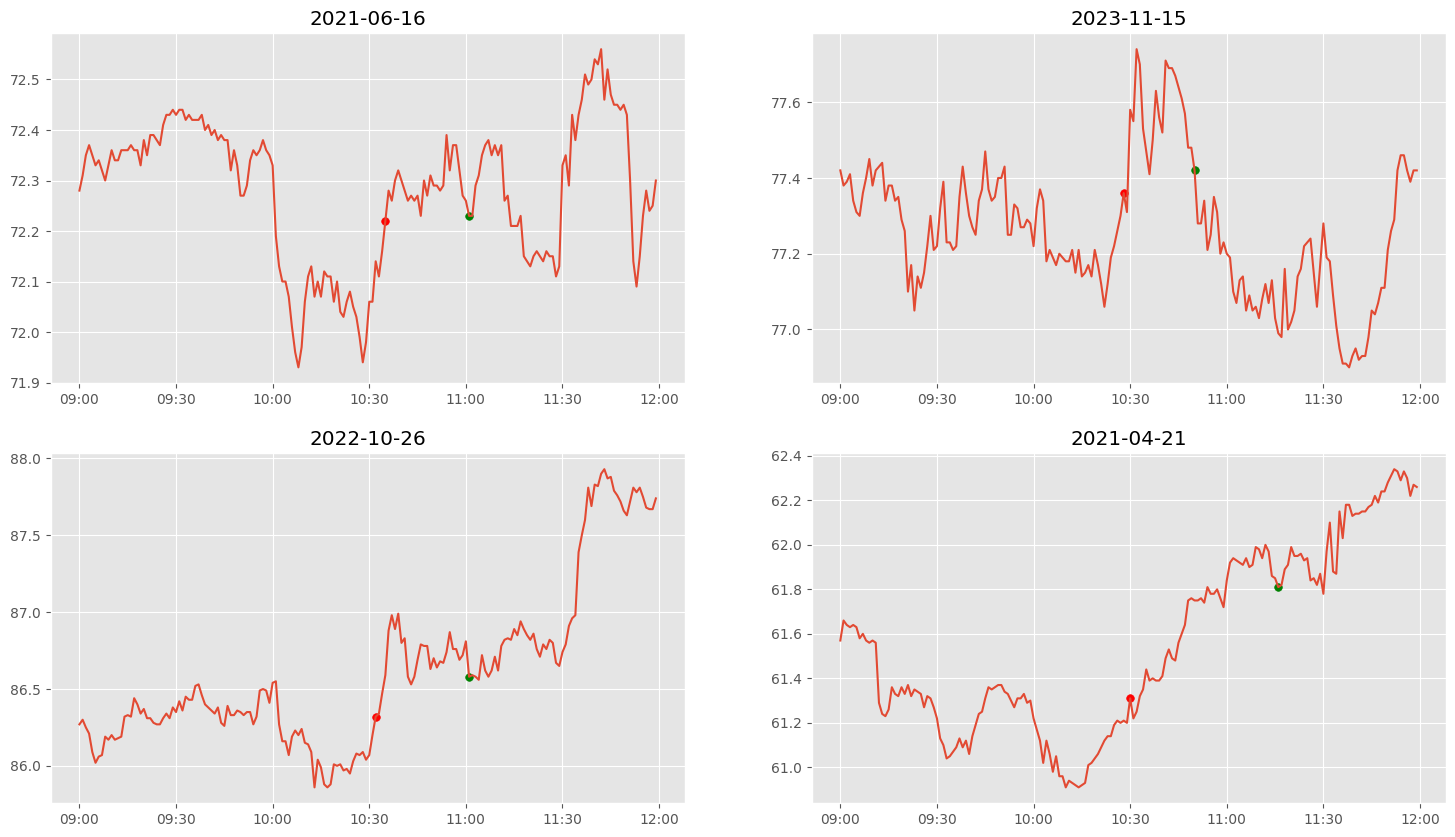

In [30]:
df_short = df_result.loc[df_result.position == 'short']
df_loss = df_short[df_short['return'] < 0].sample(4)

fig, axs = plt.subplots(2, 2, figsize=(18, 10))
counts = 0
for idx, row in df_loss.iterrows():
    df_day = df[df.index.date == idx]
    ax = axs[counts//2, counts%2]
    ax.set_title(f'{idx}')
    ax.plot(df_day.index.tz_localize(None), df_day.close)
    ax.scatter(
        pd.Timestamp(year=idx.year, month=idx.month, day=idx.day, hour=row.entry_time.hour, minute=row.entry_time.minute).tz_localize(None), 
        row.entry_price, 
        color='red', 
        s=30
    )
    ax.scatter(
        pd.Timestamp(year=idx.year, month=idx.month, day=idx.day, hour=row.exit_time.hour, minute=row.exit_time.minute).tz_localize(None), 
        row.exit_price, 
        color='green', 
        s=30
    )
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    counts += 1
plt.show()

1. Short positions are usually the one losing money.
1. The main reason is because the signal is "wrong".
1. Another reason is because it is not mean reverting.
1. Prices usually exhibit a sigmoid style pattern.

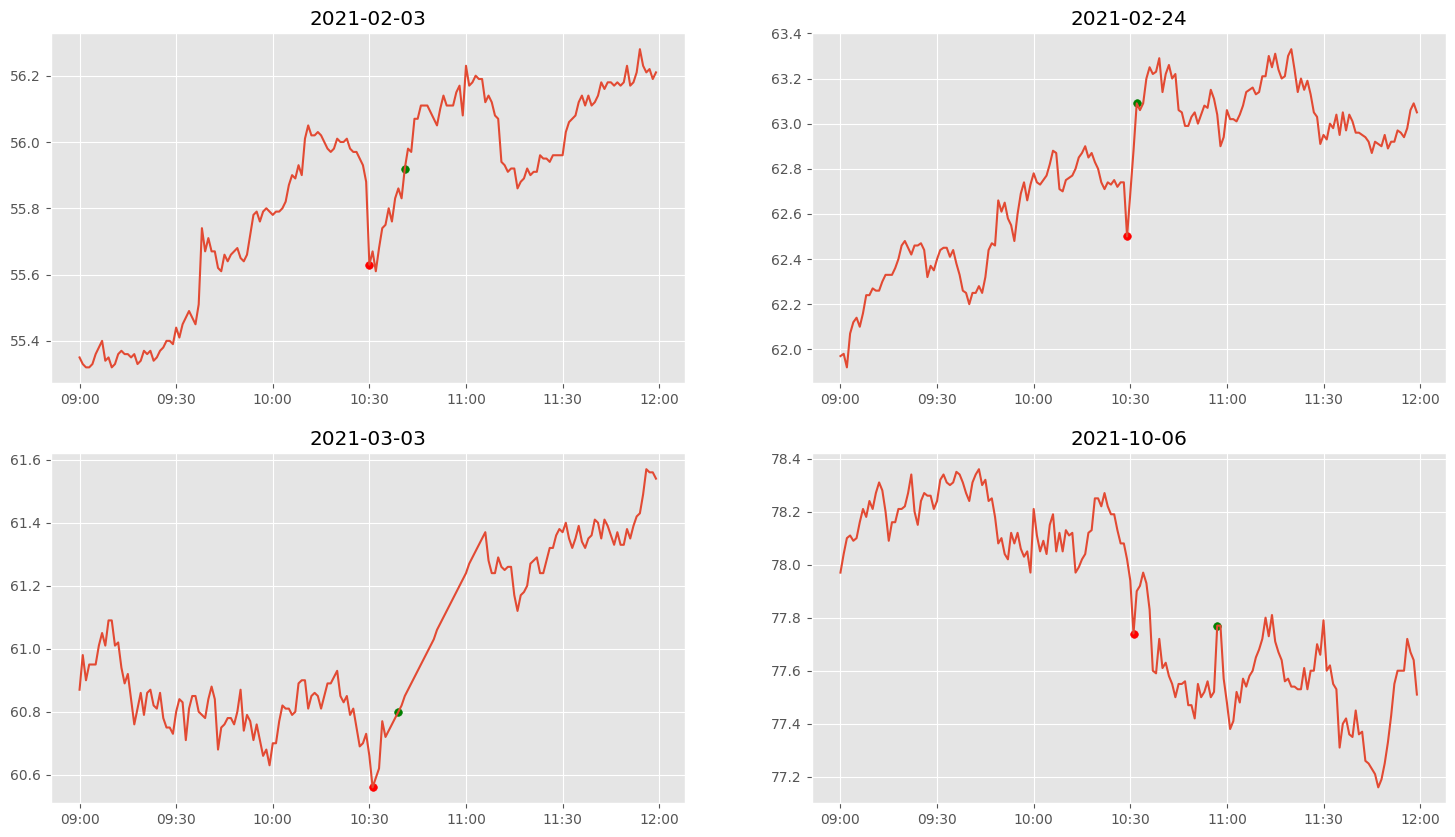

In [31]:
df_long = df_result.loc[df_result.position == 'long'].head(4)

fig, axs = plt.subplots(2, 2, figsize=(18, 10))
counts = 0
for idx, row in df_long.iterrows():
    df_day = df[df.index.date == idx]
    ax = axs[counts//2, counts%2]
    ax.set_title(f'{idx}')
    ax.plot(df_day.index.tz_localize(None), df_day.close)
    ax.scatter(
        pd.Timestamp(year=idx.year, month=idx.month, day=idx.day, hour=row.entry_time.hour, minute=row.entry_time.minute).tz_localize(None), 
        row.entry_price, 
        color='red', 
        s=30
    )
    ax.scatter(
        pd.Timestamp(year=idx.year, month=idx.month, day=idx.day, hour=row.exit_time.hour, minute=row.exit_time.minute).tz_localize(None), 
        row.exit_price, 
        color='green', 
        s=30
    )
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    counts += 1
plt.show()

# Mean Reversion 6
1. Go long if z-score less than threshold (between 1025 and 1035)
1. Go short if z-score above threshold (between 1040 and 1100)
1. Close before 1200 or if z-score reverts and direction turned

In [32]:
def mean_reversion6(
    df,
    window=30,
    long_entry_threshold=-3.0,
    long_exit_threshold=0, 
    short_entry_threshold=2.0, 
    short_exit_threshold=0,
    fast_sma=5,
    slow_sma=15
):
    long_entry_signals = []
    long_exit_signals = []

    short_entry_signals = []
    short_exit_signals = []
    for day, df_day in df.groupby(pd.Grouper(key='datetime', freq='D')):
        if df_day.shape[0] == 0:
            continue
        
        df_day = df_day.copy()
        df_day['z_score'] = (df_day.close - df_day.close.rolling(window).mean()) / df_day.close.rolling(window).std()

        df_day['sma_slow'] = df_day.close.rolling(fast_sma).mean()
        df_day['sma_fast'] = df_day.close.rolling(slow_sma).mean()
        df_day['down'] = df_day.sma_fast.vbt.crossed_below(df_day.sma_slow).replace(True, 'down').replace(False, np.nan)
        df_day['up'] = df_day.sma_fast.vbt.crossed_above(df_day.sma_slow).replace(True, 'up').replace(False, np.nan)

        df_day['direction'] = df_day.up.combine_first(df_day.down).ffill()

        long_entry = pd.Series(False, index=df_day.index)
        long_exit = pd.Series(False, index=df_day.index)
        short_entry = pd.Series(False, index=df_day.index)
        short_exit = pd.Series(False, index=df_day.index)

        for time, row in df_day.iterrows():
            time = time.time()

            if long_entry.any():
                if ((row.z_score >= long_exit_threshold) and row.direction == 'down') or (time == pd.Timestamp('11:59').time()):
                    long_exit[time] = True
                    break
            elif short_entry.any():
                if ((row.z_score <= short_exit_threshold) and row.direction == 'up') or (time == pd.Timestamp('11:59').time()):
                    short_exit[time] = True
                    break
            elif (time >= pd.Timestamp('10:25').time()) & (time <= pd.Timestamp('10:35').time()) & (row.z_score < long_entry_threshold):
                long_entry[time] = True
            elif (time >= pd.Timestamp('10:30').time()) & (time <= pd.Timestamp('11:00').time()) & (row.z_score > short_entry_threshold):
                short_entry[time] = True

        assert long_entry.sum() == long_exit.sum(), f'Long signals do no match: {day}'
        assert short_entry.sum() == short_exit.sum(), f'Short signals do no match: {day}'

        long_entry_signals.append(long_entry)
        long_exit_signals.append(long_exit)
        short_entry_signals.append(short_entry)
        short_exit_signals.append(short_exit)

    long_entry_signals = pd.concat(long_entry_signals)
    long_exit_signals = pd.concat(long_exit_signals)
    short_entry_signals = pd.concat(short_entry_signals)
    short_exit_signals = pd.concat(short_exit_signals)

    return {
        'entries': long_entry_signals,
        'exits': long_exit_signals,
        'short_entries': short_entry_signals,
        'short_exits': short_exit_signals
    }

In [33]:
signals = mean_reversion6(df, fast_sma=5, slow_sma=15)
portfolio = vbt.Portfolio.from_signals(
    close=df['close'],
    freq='1m',
    allow_partial=True,
    **signals
)
df_final['mr6'] = portfolio.stats()
portfolio.stats()

Start                         2021-01-06 09:00:00-05:00
End                           2023-12-27 11:59:00-05:00
Period                                 19 days 12:00:00
Start Value                                       100.0
End Value                                    110.102386
Total Return [%]                              10.102386
Benchmark Return [%]                          48.829766
Max Gross Exposure [%]                            100.0
Total Fees Paid                                     0.0
Max Drawdown [%]                               2.212927
Max Drawdown Duration                   3 days 21:03:00
Total Trades                                         89
Total Closed Trades                                  89
Total Open Trades                                     0
Open Trade PnL                                      0.0
Win Rate [%]                                  65.168539
Best Trade [%]                                 1.068602
Worst Trade [%]                               -1

In [34]:
portfolio.plot()

FigureWidget({
    'data': [{'legendgroup': '0',
              'line': {'color': '#1f77b4'},
              'name': 'Close',
              'showlegend': True,
              'type': 'scatter',
              'uid': 'ea73c2fb-60ae-4af4-94bc-37726250ff0e',
              'x': array([datetime.datetime(2021, 1, 6, 9, 0, tzinfo=<DstTzInfo 'America/New_York' EST-1 day, 19:00:00 STD>),
                          datetime.datetime(2021, 1, 6, 9, 1, tzinfo=<DstTzInfo 'America/New_York' EST-1 day, 19:00:00 STD>),
                          datetime.datetime(2021, 1, 6, 9, 2, tzinfo=<DstTzInfo 'America/New_York' EST-1 day, 19:00:00 STD>),
                          ...,
                          datetime.datetime(2023, 12, 27, 11, 57, tzinfo=<DstTzInfo 'America/New_York' EST-1 day, 19:00:00 STD>),
                          datetime.datetime(2023, 12, 27, 11, 58, tzinfo=<DstTzInfo 'America/New_York' EST-1 day, 19:00:00 STD>),
                          datetime.datetime(2023, 12, 27, 11, 59, tzinfo=<DstTz

In [35]:
df_result = process_signals(df, signals)
print(f"""
    Mean Long Returns: {df_result.loc[df_result.position == 'long', 'return'].mean()}
    Max Long Returns: {df_result.loc[df_result.position == 'long', 'return'].max()}
    Min Long Returns: {df_result.loc[df_result.position == 'long', 'return'].min()}

    Mean Short Returns: {df_result.loc[df_result.position == 'short', 'return'].mean()}
    Max Short Returns: {df_result.loc[df_result.position == 'short', 'return'].max()}
    Min Short Returns: {df_result.loc[df_result.position == 'short', 'return'].min()}
""")


    Mean Long Returns: 0.0038712366967042244
    Max Long Returns: 0.010686015831134595
    Min Long Returns: -0.012709572742022685

    Mean Short Returns: 0.0006163640140163878
    Max Short Returns: 0.010134717587442754
    Min Short Returns: -0.012586862462305073



# Mean Reversion 7
1. Open position between 1025 and 1035
1. Go long if z-score less than threshold
1. Go short if z-score above threshold
1. Close before 1200 or if z-score reverts and price exceeds rolling high / low

In [36]:
def mean_reversion7(
    df,
    window=30,
    long_entry_threshold=-3.0,
    long_exit_threshold=0, 
    short_entry_threshold=2.0, 
    short_exit_threshold=0,
    fast_sma=5,
    slow_sma=15
):
    long_entry_signals = []
    long_exit_signals = []

    short_entry_signals = []
    short_exit_signals = []
    for day, df_day in df.groupby(pd.Grouper(key='datetime', freq='D')):
        if df_day.shape[0] == 0:
            continue
        
        df_day = df_day.copy()
        df_day['z_score'] = (df_day.close - df_day.close.rolling(window).mean()) / df_day.close.rolling(window).std()

        df_day['high'] = df_day.close.rolling(7).max()
        df_day['low'] = df_day.close.rolling(30).min()
        df_day['peaked'] = ((df_day.close - df_day.high) / df_day.high) < 0
        df_day['bottomed'] = ((df_day.close - df_day.low) / df_day.low) > 0
        
        long_entry = pd.Series(False, index=df_day.index)
        long_exit = pd.Series(False, index=df_day.index)
        short_entry = pd.Series(False, index=df_day.index)
        short_exit = pd.Series(False, index=df_day.index)

        for time, row in df_day.iterrows():
            time = time.time()

            if long_entry.any():
                if ((row.z_score > 0) & row.peaked) or (time == pd.Timestamp('11:59').time()):
                    long_exit[time] = True
                    break
            elif short_entry.any():
                if ((row.z_score < 0) & row.bottomed) or (time == pd.Timestamp('11:59').time()):
                    short_exit[time] = True
                    break
            elif (time >= pd.Timestamp('10:25').time()) & (time <= pd.Timestamp('10:35').time()) & (row.z_score < long_entry_threshold):
                long_entry[time] = True
            elif (time >= pd.Timestamp('10:25').time()) & (time <= pd.Timestamp('10:35').time()) & (row.z_score > short_entry_threshold):
                short_entry[time] = True

        long_entry_signals.append(long_entry)
        long_exit_signals.append(long_exit)
        short_entry_signals.append(short_entry)
        short_exit_signals.append(short_exit)

    long_entry_signals = pd.concat(long_entry_signals)
    long_exit_signals = pd.concat(long_exit_signals)
    short_entry_signals = pd.concat(short_entry_signals)
    short_exit_signals = pd.concat(short_exit_signals)

    return {
        'entries': long_entry_signals,
        'exits': long_exit_signals,
        'short_entries': short_entry_signals,
        'short_exits': short_exit_signals
    }

In [37]:
signals = mean_reversion7(df)
portfolio = vbt.Portfolio.from_signals(
    close=df['close'],
    freq='1m',
    allow_partial=True,
    **signals
)
df_final['mr7'] = portfolio.stats()
portfolio.stats()

Start                         2021-01-06 09:00:00-05:00
End                           2023-12-27 11:59:00-05:00
Period                                 19 days 12:00:00
Start Value                                       100.0
End Value                                    109.664009
Total Return [%]                               9.664009
Benchmark Return [%]                          48.829766
Max Gross Exposure [%]                            100.0
Total Fees Paid                                     0.0
Max Drawdown [%]                               2.070225
Max Drawdown Duration                   4 days 16:28:00
Total Trades                                         60
Total Closed Trades                                  60
Total Open Trades                                     0
Open Trade PnL                                      0.0
Win Rate [%]                                  63.333333
Best Trade [%]                                 1.188904
Worst Trade [%]                               -1

In [38]:
df_result = process_signals(df, signals)
print(f"""
    Mean Long Returns: {df_result.loc[df_result.position == 'long', 'return'].mean()}
    Max Long Returns: {df_result.loc[df_result.position == 'long', 'return'].max()}
    Min Long Returns: {df_result.loc[df_result.position == 'long', 'return'].min()}

    Mean Short Returns: {df_result.loc[df_result.position == 'short', 'return'].mean()}
    Max Short Returns: {df_result.loc[df_result.position == 'short', 'return'].max()}
    Min Short Returns: {df_result.loc[df_result.position == 'short', 'return'].min()}
""")


    Mean Long Returns: 0.004752016807982288
    Max Long Returns: 0.011889035667106982
    Min Long Returns: -0.006956104581434377

    Mean Short Returns: 0.000749511345905552
    Max Short Returns: 0.010033444816053479
    Min Short Returns: -0.010242941562705202



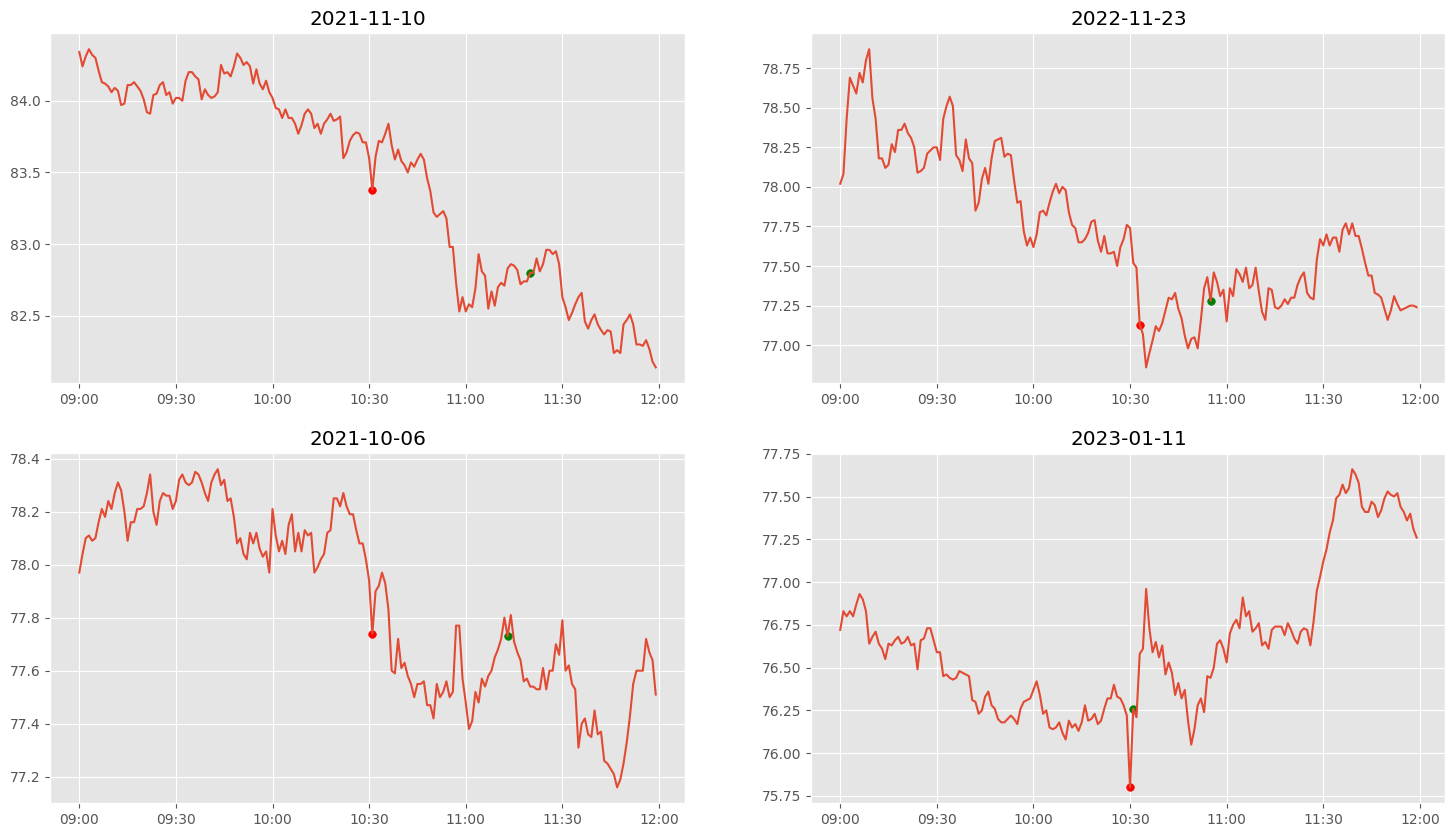

In [39]:
df_long = df_result.loc[df_result.position == 'long'].sample(4)

fig, axs = plt.subplots(2, 2, figsize=(18, 10))
counts = 0
for idx, row in df_long.iterrows():
    df_day = df[df.index.date == idx]
    ax = axs[counts//2, counts%2]
    ax.set_title(f'{idx}')
    ax.plot(df_day.index.tz_localize(None), df_day.close)
    ax.scatter(
        pd.Timestamp(year=idx.year, month=idx.month, day=idx.day, hour=row.entry_time.hour, minute=row.entry_time.minute).tz_localize(None), 
        row.entry_price, 
        color='red', 
        s=30
    )
    ax.scatter(
        pd.Timestamp(year=idx.year, month=idx.month, day=idx.day, hour=row.exit_time.hour, minute=row.exit_time.minute).tz_localize(None), 
        row.exit_price, 
        color='green', 
        s=30
    )
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    counts += 1
plt.show()

# Mean Reversion 8
Use ema

In [40]:
def mean_reversion8(
    df,
    window=30,
    long_entry_threshold=-3.0,
    long_exit_threshold=0, 
    short_entry_threshold=2.0, 
    short_exit_threshold=0,
    fast_sma=5,
    slow_sma=15
):
    long_entry_signals = []
    long_exit_signals = []

    short_entry_signals = []
    short_exit_signals = []
    for day, df_day in df.groupby(pd.Grouper(key='datetime', freq='D')):
        if df_day.shape[0] == 0:
            continue
        
        df_day = df_day.copy()
        df_day['z_score'] = (df_day.close -df_day.close.ewm(span=window, adjust=True).mean()) / df_day.close.ewm(span=window, adjust=True).std()

        df_day['sma_slow'] = df_day.close.ewm(span=slow_sma, adjust=True).mean()
        df_day['sma_fast'] = df_day.close.ewm(span=fast_sma, adjust=True).mean()
        df_day['down'] = df_day.sma_fast.vbt.crossed_below(df_day.sma_slow).replace(True, 'down').replace(False, np.nan)
        df_day['up'] = df_day.sma_fast.vbt.crossed_above(df_day.sma_slow).replace(True, 'up').replace(False, np.nan)

        df_day['direction'] = df_day.up.combine_first(df_day.down).ffill()

        long_entry = pd.Series(False, index=df_day.index)
        long_exit = pd.Series(False, index=df_day.index)
        short_entry = pd.Series(False, index=df_day.index)
        short_exit = pd.Series(False, index=df_day.index)

        for time, row in df_day.iterrows():
            time = time.time()

            if long_entry.any():
                if ((row.z_score >= long_exit_threshold) and row.direction == 'down') or (time == pd.Timestamp('11:59').time()):
                    long_exit[time] = True
                    break
            elif short_entry.any():
                if ((row.z_score <= short_exit_threshold) and row.direction == 'up') or (time == pd.Timestamp('11:59').time()):
                    short_exit[time] = True
                    break
            elif (time >= pd.Timestamp('10:25').time()) & (time <= pd.Timestamp('10:35').time()) & (row.z_score < long_entry_threshold):
                long_entry[time] = True
            elif (time >= pd.Timestamp('10:25').time()) & (time <= pd.Timestamp('10:35').time()) & (row.z_score > short_entry_threshold):
                short_entry[time] = True

        long_entry_signals.append(long_entry)
        long_exit_signals.append(long_exit)
        short_entry_signals.append(short_entry)
        short_exit_signals.append(short_exit)

    long_entry_signals = pd.concat(long_entry_signals)
    long_exit_signals = pd.concat(long_exit_signals)
    short_entry_signals = pd.concat(short_entry_signals)
    short_exit_signals = pd.concat(short_exit_signals)

    return {
        'entries': long_entry_signals,
        'exits': long_exit_signals,
        'short_entries': short_entry_signals,
        'short_exits': short_exit_signals
    }

In [41]:
signals = mean_reversion8(df, fast_sma=10, slow_sma=30)
portfolio = vbt.Portfolio.from_signals(
    close=df['close'],
    freq='1m',
    allow_partial=True,
    **signals
)
df_final['mr8'] = portfolio.stats()
portfolio.stats()

Start                         2021-01-06 09:00:00-05:00
End                           2023-12-27 11:59:00-05:00
Period                                 19 days 12:00:00
Start Value                                       100.0
End Value                                    102.971944
Total Return [%]                               2.971944
Benchmark Return [%]                          48.829766
Max Gross Exposure [%]                            100.0
Total Fees Paid                                     0.0
Max Drawdown [%]                               1.769332
Max Drawdown Duration                   5 days 18:01:00
Total Trades                                         23
Total Closed Trades                                  23
Total Open Trades                                     0
Open Trade PnL                                      0.0
Win Rate [%]                                  69.565217
Best Trade [%]                                 1.003344
Worst Trade [%]                               -0

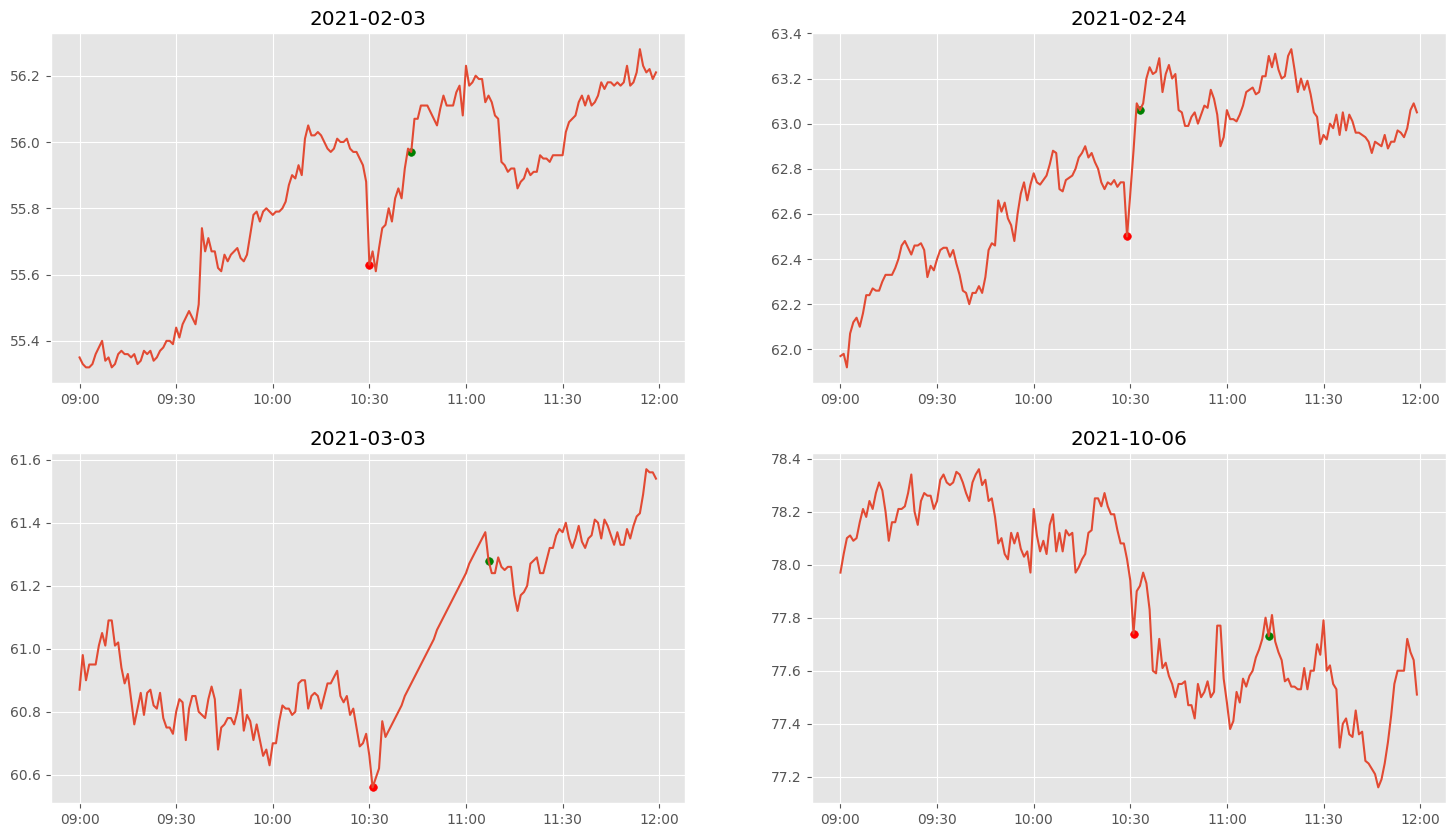

In [42]:
df_long = df_result.loc[df_result.position == 'long'].head(4)

fig, axs = plt.subplots(2, 2, figsize=(18, 10))
counts = 0
for idx, row in df_long.iterrows():
    df_day = df[df.index.date == idx]
    ax = axs[counts//2, counts%2]
    ax.set_title(f'{idx}')
    ax.plot(df_day.index.tz_localize(None), df_day.close)
    ax.scatter(
        pd.Timestamp(year=idx.year, month=idx.month, day=idx.day, hour=row.entry_time.hour, minute=row.entry_time.minute).tz_localize(None), 
        row.entry_price, 
        color='red', 
        s=30
    )
    ax.scatter(
        pd.Timestamp(year=idx.year, month=idx.month, day=idx.day, hour=row.exit_time.hour, minute=row.exit_time.minute).tz_localize(None), 
        row.exit_price, 
        color='green', 
        s=30
    )
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    counts += 1
plt.show()

In [43]:
df_final = pd.DataFrame(df_final)

In [44]:
df_final = df_final.T
df_final.head()

,Start,End,Period,Start Value,End Value,Total Return [%],Benchmark Return [%],Max Gross Exposure [%],Total Fees Paid,Max Drawdown [%],...,Avg Winning Trade [%],Avg Losing Trade [%],Avg Winning Trade Duration,Avg Losing Trade Duration,Profit Factor,Expectancy,Sharpe Ratio,Calmar Ratio,Omega Ratio,Sortino Ratio
hold,2021-01-06 09:00:00-05:00,2023-12-27 11:59:00-05:00,19 days 12:00:00,100.0,97.249996,-2.750004,48.829766,100.0,0.0,13.100505,...,0.794544,-0.830588,0 days 01:29:00,0 days 01:29:00,0.95887,-0.023194,-0.584773,-3.104005,0.996759,-0.829872
sma,2021-01-06 09:00:00-05:00,2023-12-27 11:59:00-05:00,19 days 12:00:00,100.0,69.120975,-30.879025,48.829766,100.0,0.0,57.27676,...,0.820411,-0.451798,0 days 00:23:43.500000,0 days 00:09:33.908948194,0.896182,-0.041164,-2.233656,-1.744172,0.963713,-2.824056
mr1,2021-01-06 09:00:00-05:00,2023-12-27 11:59:00-05:00,19 days 12:00:00,100.0,104.306599,4.306599,48.829766,100.0,0.0,2.212927,...,0.459174,-1.270957,0 days 00:10:05,0 days 00:54:00,4.277455,0.331277,8.82647,54.303859,1.503011,14.875407
mr2,2021-01-06 09:00:00-05:00,2023-12-27 11:59:00-05:00,19 days 12:00:00,100.0,109.493342,9.493342,48.829766,100.0,0.0,2.05809,...,0.399922,-0.34322,0 days 00:10:21,0 days 00:32:21,2.318604,0.158222,10.647641,216.745162,1.232087,16.590795
mr3,2021-01-06 09:00:00-05:00,2023-12-27 11:59:00-05:00,19 days 12:00:00,100.0,102.580178,2.580178,48.829766,100.0,0.0,2.436223,...,0.751894,-1.039387,0 days 00:30:00,0 days 01:07:30,1.597001,0.198475,3.50009,25.078208,1.097238,5.236979


<Axes: >

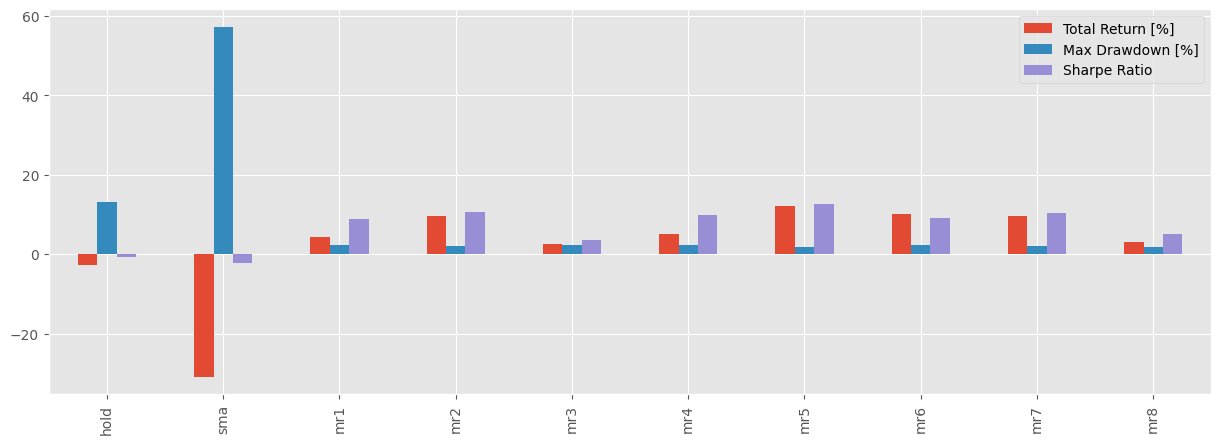

In [45]:
df_final[[
    'Total Return [%]',
    'Max Drawdown [%]',
    'Sharpe Ratio',
]].plot.bar(figsize=(15,5))

<Axes: >

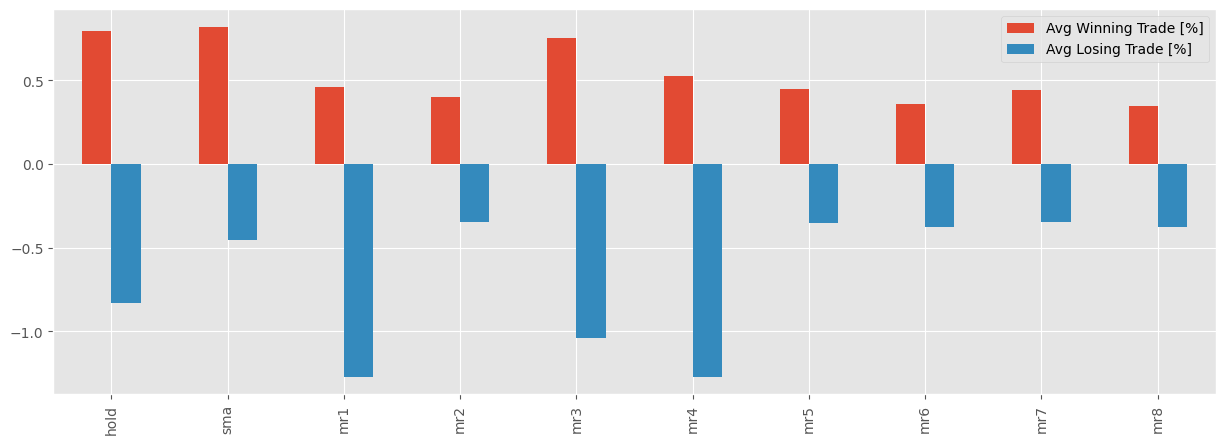

In [46]:
df_final[[
    'Avg Winning Trade [%]',
    'Avg Losing Trade [%]'
]].plot.bar(figsize=(15,5))

In [47]:
df_final[['Avg Winning Trade Duration', 'Avg Losing Trade Duration']]

# no need to trade until 4 o'clock, win trade usually happens in 10 minutes

,Avg Winning Trade Duration,Avg Losing Trade Duration
hold,0 days 01:29:00,0 days 01:29:00
sma,0 days 00:23:43.500000,0 days 00:09:33.908948194
mr1,0 days 00:10:05,0 days 00:54:00
mr2,0 days 00:10:21,0 days 00:32:21
mr3,0 days 00:30:00,0 days 01:07:30
mr4,0 days 00:11:00,0 days 00:54:00
mr5,0 days 00:11:58.536585365,0 days 00:32:50.526315789
mr6,0 days 00:13:41.379310344,0 days 00:35:54
mr7,0 days 00:11:31.578947368,0 days 00:33:32.727272727
mr8,0 days 00:12:41.250000,0 days 00:42:08.571428571


# Testing Mean Reversion 5

## Test on 2024

In [48]:
# with pd.HDFStore('./large_files/yahoo.h5', mode='r') as store:
#     df_ = store.get('data/cl')
# df = df_.set_index('datetime', drop=False)
# df = df.loc[df.index.day_of_week == 2]
# df = df[(df.index.hour >= 9) & (df.index.hour < 12)]
# df = df.drop('adj close', axis=1)

# df = pd.concat([df, df_year]).reset_index(drop=True).drop_duplicates('datetime').sort_values('datetime')
# df = df.set_index('datetime', drop=False)
df = df_year

In [49]:
signals = mean_reversion5(df)
portfolio = vbt.Portfolio.from_signals(
    close=df['close'],
    freq='1m',
    allow_partial=True,
    **signals
)
portfolio.stats()

Start                         2024-01-03 09:00:00-05:00
End                           2024-02-28 11:59:00-05:00
Period                                  1 days 03:00:00
Start Value                                       100.0
End Value                                    100.880086
Total Return [%]                               0.880086
Benchmark Return [%]                          10.878187
Max Gross Exposure [%]                            100.0
Total Fees Paid                                     0.0
Max Drawdown [%]                               1.479047
Max Drawdown Duration                   0 days 08:59:00
Total Trades                                          6
Total Closed Trades                                   6
Total Open Trades                                     0
Open Trade PnL                                      0.0
Win Rate [%]                                  83.333333
Best Trade [%]                                 0.573813
Worst Trade [%]                               -0

In [50]:
portfolio.plot()

FigureWidget({
    'data': [{'legendgroup': '0',
              'line': {'color': '#1f77b4'},
              'name': 'Close',
              'showlegend': True,
              'type': 'scatter',
              'uid': 'bfcc6776-0985-4edc-b852-88c97fc6c0b4',
              'x': array([datetime.datetime(2024, 1, 3, 9, 0, tzinfo=<DstTzInfo 'America/New_York' EST-1 day, 19:00:00 STD>),
                          datetime.datetime(2024, 1, 3, 9, 1, tzinfo=<DstTzInfo 'America/New_York' EST-1 day, 19:00:00 STD>),
                          datetime.datetime(2024, 1, 3, 9, 2, tzinfo=<DstTzInfo 'America/New_York' EST-1 day, 19:00:00 STD>),
                          ...,
                          datetime.datetime(2024, 2, 28, 11, 57, tzinfo=<DstTzInfo 'America/New_York' EST-1 day, 19:00:00 STD>),
                          datetime.datetime(2024, 2, 28, 11, 58, tzinfo=<DstTzInfo 'America/New_York' EST-1 day, 19:00:00 STD>),
                          datetime.datetime(2024, 2, 28, 11, 59, tzinfo=<DstTzInf

In [51]:
signals = mean_reversion2(df)
portfolio = vbt.Portfolio.from_signals(
    close=df['close'],
    freq='1m',
    allow_partial=True,
    **signals
)
portfolio.stats()

Start                         2024-01-03 09:00:00-05:00
End                           2024-02-28 11:59:00-05:00
Period                                  1 days 03:00:00
Start Value                                       100.0
End Value                                    100.500053
Total Return [%]                               0.500053
Benchmark Return [%]                          10.878187
Max Gross Exposure [%]                            100.0
Total Fees Paid                                     0.0
Max Drawdown [%]                               1.479047
Max Drawdown Duration                   0 days 17:54:00
Total Trades                                          6
Total Closed Trades                                   6
Total Open Trades                                     0
Open Trade PnL                                      0.0
Win Rate [%]                                  83.333333
Best Trade [%]                                 0.492611
Worst Trade [%]                               -0

In [52]:
portfolio.plot()

FigureWidget({
    'data': [{'legendgroup': '0',
              'line': {'color': '#1f77b4'},
              'name': 'Close',
              'showlegend': True,
              'type': 'scatter',
              'uid': 'ad8eaa9a-1ac5-4cbb-a9c4-a356f8ef5dd6',
              'x': array([datetime.datetime(2024, 1, 3, 9, 0, tzinfo=<DstTzInfo 'America/New_York' EST-1 day, 19:00:00 STD>),
                          datetime.datetime(2024, 1, 3, 9, 1, tzinfo=<DstTzInfo 'America/New_York' EST-1 day, 19:00:00 STD>),
                          datetime.datetime(2024, 1, 3, 9, 2, tzinfo=<DstTzInfo 'America/New_York' EST-1 day, 19:00:00 STD>),
                          ...,
                          datetime.datetime(2024, 2, 28, 11, 57, tzinfo=<DstTzInfo 'America/New_York' EST-1 day, 19:00:00 STD>),
                          datetime.datetime(2024, 2, 28, 11, 58, tzinfo=<DstTzInfo 'America/New_York' EST-1 day, 19:00:00 STD>),
                          datetime.datetime(2024, 2, 28, 11, 59, tzinfo=<DstTzInf

In [53]:
with pd.HDFStore('./large_files/data_20240312.h5') as store:
    df_cl = store.get('data/cl')

def filter_data(df):
    df = df.set_index('datetime', drop=False)
    df = df.loc[df.index.year.isin([2024])]
    df = df.loc[df.index.day_of_week != 2]
    df = df[(df.index.hour >= 9) & (df.index.hour < 12)]

    return df

df_cl = filter_data(df_cl)

signals = mean_reversion5(df_cl)
portfolio = vbt.Portfolio.from_signals(
    close=df_cl['close'],
    freq='1m',
    allow_partial=True,
    **signals
)
portfolio.stats()

Start                         2024-01-02 09:00:00-05:00
End                           2024-03-05 11:59:00-05:00
Period                                  4 days 09:00:00
Start Value                                       100.0
End Value                                     100.88883
Total Return [%]                                0.88883
Benchmark Return [%]                           7.032637
Max Gross Exposure [%]                            100.0
Total Fees Paid                                     0.0
Max Drawdown [%]                               0.690044
Max Drawdown Duration                   1 days 08:50:00
Total Trades                                          9
Total Closed Trades                                   9
Total Open Trades                                     0
Open Trade PnL                                      0.0
Win Rate [%]                                  66.666667
Best Trade [%]                                 0.381471
Worst Trade [%]                               -0

In [54]:
portfolio.plot()

FigureWidget({
    'data': [{'legendgroup': '0',
              'line': {'color': '#1f77b4'},
              'name': 'Close',
              'showlegend': True,
              'type': 'scatter',
              'uid': '71ec9a9c-5a9f-4f12-af66-6118d48b1ccd',
              'x': array([datetime.datetime(2024, 1, 2, 9, 0, tzinfo=<DstTzInfo 'America/New_York' EST-1 day, 19:00:00 STD>),
                          datetime.datetime(2024, 1, 2, 9, 1, tzinfo=<DstTzInfo 'America/New_York' EST-1 day, 19:00:00 STD>),
                          datetime.datetime(2024, 1, 2, 9, 2, tzinfo=<DstTzInfo 'America/New_York' EST-1 day, 19:00:00 STD>),
                          ...,
                          datetime.datetime(2024, 3, 5, 11, 57, tzinfo=<DstTzInfo 'America/New_York' EST-1 day, 19:00:00 STD>),
                          datetime.datetime(2024, 3, 5, 11, 58, tzinfo=<DstTzInfo 'America/New_York' EST-1 day, 19:00:00 STD>),
                          datetime.datetime(2024, 3, 5, 11, 59, tzinfo=<DstTzInfo '